# Прогнозирование оттока клиентов оператора связи

# Введение

Оператор связи «Ниединогоразрыва.ком» столкнулся с оттоком клиентов. Компания хочет научиться прогнозировать его. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Цели и задачи

Цель - разработать модель машинного обучения, которая будет предсказывать отток клиентов оператора связи «Ниединогоразрыва.ком», чтобы на основе этих данных проводить мероприятия по удержанию текущих клиентов в компании (с помощью промокодов и специальных условий).

Задачи:
    
    1. Загрузить и изучить данные
    2. Подготовить данные для анализа
    3. Построить несколько моделей предсказаний 
    4. Выбрать оптимальную модель и протестировать ее
    5. Написать выводы и рекомендации

## План

    1. Загрузить и изучить данные
        1) Загрузить 4 исходных базы данных
        2) Описать их с помощью describe() и info()
        3) Проверить дубликаты
        
    2. Подготовить данные для анализа
        1) Соединение баз данных в итоговую таблицу
        2) Создание новых признаков
        3) Заполнение пропусков
        4) Отбор признаков для анализа 
        5) Перекодировка признаков
        6) Замена типов данных   
        7) Исследуем корреляцию (с помощью библиотеки phik)
        8) Оцениваем дисбаланс классов
        9) Анализируем распределение признаков
        10) Обработка аномальных значений
 
    3. Построить несколько моделей предсказаний 
        1) Разделение выборки на обучающую и тестовую
        2) С помощью pipeline: нормализуем датасет (StandartScaler) 
        3) С помощью pipeline: кодируем категориальные признаки (OneHotEncoder)
        4) С помощью кросс-валидации построить следующие модели: логистическая регрессия(LogisticRegression), случайный лес(RandomForestClassifier), модели градиентного бустинга (LGBMClassifier, CatBoostClassifier).
        
    4. Выбрать оптимальную модель и протестировать ее на тестовой выборке (по метрике AUC-ROC)
    5. Написать выводы и рекомендации

# Загрузка данных

In [1]:
!pip install IPython

In [2]:
!pip install scikit-learn==1.1.3

In [3]:
!pip install phik

In [4]:
!pip install yellowbrick

     |████████████████████████████████| 282 kB 2.5 MB/s eta 0:00:01


In [5]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,10)
pd.set_option('max_columns', None)

## Информация о договорах

Загрузим базу с информацией о договорах.

In [6]:
df_contract = pd.read_csv('/datasets/contract_new.csv', sep=',')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
print('Кол-во дубликатов в базе о контрактах (contract_new)', df_contract.duplicated().sum())

Кол-во дубликатов в базе о контрактах (contract_new) 0


Всего в базе 7043 наблюдения, дубликатов, пропущенных значений нет.

## Персональные данные клиентов

Загрузим базу с персональными данными клиентов.

In [9]:
df_personal = pd.read_csv('/datasets/personal_new.csv', sep=',')
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
print('Кол-во дубликатов в базе с персональной информацией (personal_new)', df_personal.duplicated().sum())

Кол-во дубликатов в базе с персональной информацией (personal_new) 0


Всего в базе 7043 наблюдения, дубликатов, пропущенных значений нет.

## Интернет-услуги

Загрузим базу с информацией об интернет-услугах.

In [12]:
df_internet = pd.read_csv('/datasets/internet_new.csv', sep=',')
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
print('Кол-во дубликатов в базе с информацией об интернет-услугах (internet_new)', df_internet.duplicated().sum())

Кол-во дубликатов в базе с информацией об интернет-услугах (internet_new) 0


Всего в базе 5517 наблюдения, дубликатов, пропущенных значений нет.

## Услуги телефонии

Загрузим базу с информацией об услугах телефонии.

In [15]:
df_phone = pd.read_csv('/datasets/phone_new.csv', sep=',')
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
print('Кол-во дубликатов в базе с информацией об услугах телефонии (phone_new)', df_phone.duplicated().sum())

Кол-во дубликатов в базе с информацией об услугах телефонии (phone_new) 0


Всего в базе 6361 наблюдения, дубликатов, пропущенных значений нет.

# Подготовка данных

## Итоговая таблица

Соединим имеющиеся базы данных в одну.

In [18]:
df = df_contract.merge(df_personal, on='customerID', how='outer')

In [19]:
df = df.merge(df_internet, on='customerID', how='outer')

In [20]:
df = df.merge(df_phone, on='customerID', how='outer')

Посмотрим на итоговую таблицу:

In [21]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [22]:
#приведем названия переменных к "змеиному стилю"
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

## Создание новых переменных

### Services

Создадим новую переменную, которая будет содержать следующую информацию:

Если клиент пользуется только услугами интернета - "internet"
Если клиент пользуется только услугами телефонии - "phone"
Если клиент пользуется услугами интернета и телефонии - "int_and_ph"

In [24]:
#по пропускам заполним информацию о пользовании интернетом
df.loc[df['internet_service'].isna() == True, 'internet'] = 0
df.loc[df['internet_service'].isna() == False, 'internet'] = 1

In [25]:
#заполним информацию о пользовании телефоном
df.loc[df['multiple_lines'].isna() == True, 'phone'] = 0
df.loc[df['multiple_lines'].isna() == False, 'phone'] = 1

In [26]:
#создадим функцию по нужным нам условиям
def services(internet, phone):
    
    if internet == 1 and phone == 0:
        return 'internet'
    if internet == 0 and phone == 1:
        return 'phone'
    return 'int_and_ph' 

In [27]:
#создадим новый столбец и применим функцию services:
df['services'] = df.apply(lambda row: services(row['internet'], row['phone']), axis=1)

In [28]:
df.head()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,internet,phone,services
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1.0,0.0,internet
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1.0,1.0,int_and_ph
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1.0,1.0,int_and_ph
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1.0,0.0,internet
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1.0,1.0,int_and_ph


### Сontract_duration

Вычислим длительность контракта клиента (в днях). 

In [29]:
#приведем переменную с датой заключения контракта к типу "дата"

df['begin_date'] = pd.to_datetime(df['begin_date'], format= '%Y-%m-%d') 

#создадим новый столбец с текущей датой (1 февраля 2020)
df['current_date'] = '2020-02-01'
df['current_date'] = pd.to_datetime(df['current_date'], format= '%Y-%m-%d')

In [30]:
#заполним значения end_date, где нет даты нереалистичной датой 1900г и приведем переменную к типу "дата"
df.loc[df['end_date'] == "No", 'end_date'] = '1900-01-01'
df['end_date'] = pd.to_datetime(df['end_date'], format= '%Y-%m-%d')

In [31]:
df.loc[df['end_date'] != "1900-01-01", 'сontract_duration'] = (df['end_date'] - df['begin_date']) / pd.Timedelta(days=1)
df.loc[df['end_date'] == "1900-01-01", 'сontract_duration'] = (df['current_date'] - df['begin_date']) / pd.Timedelta(days=1)

In [32]:
df.head(20)

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,internet,phone,services,current_date,сontract_duration
0,7590-VHVEG,2020-01-01,1900-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1.0,0.0,internet,2020-02-01,31.0
1,5575-GNVDE,2017-04-01,1900-01-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1.0,1.0,int_and_ph,2020-02-01,1036.0
2,3668-QPYBK,2019-10-01,1900-01-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1.0,1.0,int_and_ph,2020-02-01,123.0
3,7795-CFOCW,2016-05-01,1900-01-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1.0,0.0,internet,2020-02-01,1371.0
4,9237-HQITU,2019-09-01,1900-01-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1.0,1.0,int_and_ph,2020-02-01,153.0
5,9305-CDSKC,2019-03-01,1900-01-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,1.0,1.0,int_and_ph,2020-02-01,337.0
6,1452-KIOVK,2018-04-01,1900-01-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,1.0,1.0,int_and_ph,2020-02-01,671.0
7,6713-OKOMC,2019-04-01,1900-01-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN,1.0,0.0,internet,2020-02-01,306.0
8,7892-POOKP,2017-07-01,1900-01-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,1.0,1.0,int_and_ph,2020-02-01,945.0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,1.0,1.0,int_and_ph,2020-02-01,882.0


Посчитана длина договора для текущих и оставшихся клиентов.

### Payment_difference

Вычислим абсолютную переплату клиента за услуги (разница между фактической оплатой и расчетной - месячная плата, умноженная на кол-во месяцев, которые клиент является абонентом). Возможно, большая переплата из-за штрафов может влиять на его желание уйти из компании.

В переменной общих платежей есть пропуски, рассмотрим их подробнее.

In [33]:
df.query('total_charges == " "')

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,internet,phone,services,current_date,сontract_duration
488,4472-LVYGI,2020-02-01,1900-01-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,1.0,0.0,internet,2020-02-01,0.0
753,3115-CZMZD,2020-02-01,1900-01-01,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0.0,1.0,phone,2020-02-01,0.0
936,5709-LVOEQ,2020-02-01,1900-01-01,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,1.0,1.0,int_and_ph,2020-02-01,0.0
1082,4367-NUYAO,2020-02-01,1900-01-01,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0.0,1.0,phone,2020-02-01,0.0
1340,1371-DWPAZ,2020-02-01,1900-01-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,1.0,0.0,internet,2020-02-01,0.0
3331,7644-OMVMY,2020-02-01,1900-01-01,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0.0,1.0,phone,2020-02-01,0.0
3826,3213-VVOLG,2020-02-01,1900-01-01,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0.0,1.0,phone,2020-02-01,0.0
4380,2520-SGTTA,2020-02-01,1900-01-01,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0.0,1.0,phone,2020-02-01,0.0
5218,2923-ARZLG,2020-02-01,1900-01-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0.0,1.0,phone,2020-02-01,0.0
6670,4075-WKNIU,2020-02-01,1900-01-01,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,1.0,1.0,int_and_ph,2020-02-01,0.0


Все клиенты, у которых нет значения в поле total_charges, только что заключили договор с компанией и не успели попользоваться услугами месяц. Заполним пропуски 0.

In [34]:
df.loc[df['total_charges'] == " ", 'total_charges'] = '0'

In [35]:
df['total_charges'] = pd.to_numeric(df['total_charges'], downcast="float")
df['payment_difference'] = df['total_charges'] - (df['monthly_charges'] / 30.4 * df['сontract_duration'])

In [36]:
df.head()

,customer_i_d,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,internet,phone,services,current_date,сontract_duration,payment_difference
0,7590-VHVEG,2020-01-01,1900-01-01,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1.0,0.0,internet,2020-02-01,31.0,0.600856
1,5575-GNVDE,2017-04-01,1900-01-01,One year,No,Mailed check,56.95,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1.0,1.0,int_and_ph,2020-02-01,1036.0,131.044035
2,3668-QPYBK,2019-10-01,1900-01-01,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1.0,1.0,int_and_ph,2020-02-01,123.0,8.290064
3,7795-CFOCW,2016-05-01,1900-01-01,One year,No,Bank transfer (automatic),42.30,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1.0,0.0,internet,2020-02-01,1371.0,52.925633
4,9237-HQITU,2019-09-01,1900-01-01,Month-to-month,Yes,Electronic check,70.70,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1.0,1.0,int_and_ph,2020-02-01,153.0,-2.325658


## Заполнение пропущенных значений

В итоговой таблице появились пропуски. Скорее всего, из-за того, что не у всех пользователей подключены одновременно телефония и интернет-услуги. 

Заполним пропуски в блоке, связанном с **телефонией**. Предположим, что у пользователей, которые не пользуются услугами телефонии, нет возможности ведения параллельных линий во время звонка. Обозначим таких пользователей "no_phone"

In [37]:
df['multiple_lines'].unique()

array([nan, 'No', 'Yes'], dtype=object)

In [38]:
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

Блок интернет-услуг. Заполним пропуски в переменной internet_service значением "no_internet". Обозначим так пользователей, которые не пользуются интернетом. 

In [39]:
df['internet_service'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

In [40]:
df['internet_service'] = df['internet_service'].fillna('no_internet')

Проверим, пропуски в остальных переменных блока про интернет возникают только у тех, пользователей, которые не пользуются интернетом, или нет.

In [41]:
df_no_internet = df.query('internet_service == "no_internet"')
df_no_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 11 to 7037
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_i_d        1526 non-null   object        
 1   begin_date          1526 non-null   datetime64[ns]
 2   end_date            1526 non-null   datetime64[ns]
 3   type                1526 non-null   object        
 4   paperless_billing   1526 non-null   object        
 5   payment_method      1526 non-null   object        
 6   monthly_charges     1526 non-null   float64       
 7   total_charges       1526 non-null   float32       
 8   gender              1526 non-null   object        
 9   senior_citizen      1526 non-null   int64         
 10  partner             1526 non-null   object        
 11  dependents          1526 non-null   object        
 12  internet_service    1526 non-null   object        
 13  online_security     0 non-null      object     

Все пропуски в переменных связаны с тем, что пользователь не пользуется интернет-услугами. Заполним пропущенные значения следующим образом - что пользователь не пользуется интернет-услугами.

In [42]:
#список возможных значений

print(df['online_security'].unique())
print(df['online_backup'].unique())
print(df['device_protection'].unique())
print(df['tech_support'].unique())
print(df['streaming_t_v'].unique())
print(df['streaming_movies'].unique())

['No' 'Yes' nan]
['Yes' 'No' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]
['No' 'Yes' nan]


In [43]:
#заполняем пропуски

df['online_security'] = df['online_security'].fillna('no_internet')
df['online_backup'] = df['online_backup'].fillna('no_internet')
df['device_protection'] = df['device_protection'].fillna('no_internet')
df['tech_support'] = df['tech_support'].fillna('no_internet')
df['streaming_t_v'] = df['streaming_t_v'].fillna('no_internet')
df['streaming_movies'] = df['streaming_movies'].fillna('no_internet')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_i_d        7043 non-null   object        
 1   begin_date          7043 non-null   datetime64[ns]
 2   end_date            7043 non-null   datetime64[ns]
 3   type                7043 non-null   object        
 4   paperless_billing   7043 non-null   object        
 5   payment_method      7043 non-null   object        
 6   monthly_charges     7043 non-null   float64       
 7   total_charges       7043 non-null   float32       
 8   gender              7043 non-null   object        
 9   senior_citizen      7043 non-null   int64         
 10  partner             7043 non-null   object        
 11  dependents          7043 non-null   object        
 12  internet_service    7043 non-null   object        
 13  online_security     7043 non-null   object      

Все пропуски заполнены, идем дальше.

## Отбор признаков для анализа


Для анализа подойдут не все признаки, которые представлены в датасете. **Исключим из анализа** такие переменные, как:

```
customer_i_d (не несет полезную информацию)
begin_date (используем новый созданный признак сontract_duration)
internet (используем новый созданный признак services)
phone (используем новый созданный признак services)
current_date (используем новый созданный признак сontract_duration)
```

In [45]:
df = df.loc[:, 'end_date':'payment_difference']

df = df.drop('internet', axis= 1)
df = df.drop('phone', axis= 1)
df = df.drop('current_date', axis= 1)
df.head()

,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,services,сontract_duration,payment_difference
0,1900-01-01,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,internet,31.0,0.600856
1,1900-01-01,One year,No,Mailed check,56.95,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,int_and_ph,1036.0,131.044035
2,1900-01-01,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,int_and_ph,123.0,8.290064
3,1900-01-01,One year,No,Bank transfer (automatic),42.30,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,internet,1371.0,52.925633
4,1900-01-01,Month-to-month,Yes,Electronic check,70.70,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,int_and_ph,153.0,-2.325658


## Перекодирование признаков

Перекодируем целевую переменную **end_date** в нужный формат. Там, где проставлена дата окончания контракта, будет значение 1 - клиент ушел из компании, где нет даты - 0 (клиент еще пользуется услугами).

In [46]:
df.loc[df['end_date'] == "1900-01-01", 'end_date'] = 0
df.loc[df['end_date'] != 0, 'end_date'] = 1
df.head(20)

,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,services,сontract_duration,payment_difference
0,0,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,internet,31.0,0.600856
1,0,One year,No,Mailed check,56.95,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,int_and_ph,1036.0,131.044035
2,0,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,int_and_ph,123.0,8.290064
3,0,One year,No,Bank transfer (automatic),42.30,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,internet,1371.0,52.925633
4,0,Month-to-month,Yes,Electronic check,70.70,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,int_and_ph,153.0,-2.325658
5,0,Month-to-month,Yes,Electronic check,99.65,1150.959961,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,int_and_ph,337.0,46.287264
6,0,Month-to-month,Yes,Credit card (automatic),89.10,2058.209961,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,int_and_ph,671.0,91.561935
7,0,Month-to-month,No,Mailed check,29.75,300.480011,Female,0,No,No,DSL,Yes,No,No,No,No,No,no_phone,internet,306.0,1.022774
8,0,Month-to-month,Yes,Electronic check,104.80,3573.679932,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,int_and_ph,945.0,315.916774
9,1,One year,No,Bank transfer (automatic),56.15,1628.349976,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No,int_and_ph,882.0,-0.738840


In [47]:
df['end_date'].unique()

array([0, 1], dtype=object)

Переименуем целевую переменную, чтобы название больше отражало суть переменной:

In [48]:
df.rename(columns = {'end_date':'exited'}, inplace = True )
df.head()

,exited,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,services,сontract_duration,payment_difference
0,0,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,internet,31.0,0.600856
1,0,One year,No,Mailed check,56.95,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,int_and_ph,1036.0,131.044035
2,0,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,int_and_ph,123.0,8.290064
3,0,One year,No,Bank transfer (automatic),42.30,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,internet,1371.0,52.925633
4,0,Month-to-month,Yes,Electronic check,70.70,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,int_and_ph,153.0,-2.325658


## Изменение типов данных ячеек

Проверим, у всех ли переменных проставлен правильный тип данных.

In [49]:
df.head()

,exited,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,services,сontract_duration,payment_difference
0,0,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_phone,internet,31.0,0.600856
1,0,One year,No,Mailed check,56.95,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,int_and_ph,1036.0,131.044035
2,0,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,int_and_ph,123.0,8.290064
3,0,One year,No,Bank transfer (automatic),42.30,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_phone,internet,1371.0,52.925633
4,0,Month-to-month,Yes,Electronic check,70.70,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,int_and_ph,153.0,-2.325658


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   exited              7043 non-null   object 
 1   type                7043 non-null   object 
 2   paperless_billing   7043 non-null   object 
 3   payment_method      7043 non-null   object 
 4   monthly_charges     7043 non-null   float64
 5   total_charges       7043 non-null   float32
 6   gender              7043 non-null   object 
 7   senior_citizen      7043 non-null   int64  
 8   partner             7043 non-null   object 
 9   dependents          7043 non-null   object 
 10  internet_service    7043 non-null   object 
 11  online_security     7043 non-null   object 
 12  online_backup       7043 non-null   object 
 13  device_protection   7043 non-null   object 
 14  tech_support        7043 non-null   object 
 15  streaming_t_v       7043 non-null   object 
 16  stream

Поменяем тип данных целевой переменной на целочисленный.

In [51]:
df['exited'] = df['exited'].astype('int64')

Поменяем тип данных **senior_citizen** на object.

In [52]:
df['senior_citizen'] = df['senior_citizen'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   exited              7043 non-null   int64  
 1   type                7043 non-null   object 
 2   paperless_billing   7043 non-null   object 
 3   payment_method      7043 non-null   object 
 4   monthly_charges     7043 non-null   float64
 5   total_charges       7043 non-null   float32
 6   gender              7043 non-null   object 
 7   senior_citizen      7043 non-null   object 
 8   partner             7043 non-null   object 
 9   dependents          7043 non-null   object 
 10  internet_service    7043 non-null   object 
 11  online_security     7043 non-null   object 
 12  online_backup       7043 non-null   object 
 13  device_protection   7043 non-null   object 
 14  tech_support        7043 non-null   object 
 15  streaming_t_v       7043 non-null   object 
 16  stream

## Корреляция признаков

Проверим корреляцию признаков (в том числе целевой переменной) с помощью библиотеки phik.

Построим матрицу корреляции.

In [53]:
#выбираем числовые переменные

interval_cols = df[['monthly_charges', 'total_charges', 'сontract_duration', 'payment_difference']]

In [54]:
interval_cols

,monthly_charges,total_charges,сontract_duration,payment_difference
0,29.85,31.040001,31.0,0.600856
1,56.95,2071.840088,1036.0,131.044035
2,53.85,226.169998,123.0,8.290064
3,42.30,1960.599976,1371.0,52.925633
4,70.70,353.500000,153.0,-2.325658
...,...,...,...,...
7038,84.80,2035.199951,730.0,-1.115838
7039,103.20,7430.399902,2191.0,-7.468519
7040,29.60,325.600006,337.0,-2.531573
7041,74.40,520.799988,215.0,-5.384223


In [55]:
phik_overview = df.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,exited,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,services,сontract_duration,payment_difference
exited,1.00,0.09,0.08,0.21,0.23,0.30,0.01,0.09,0.23,0.05,0.06,0.06,0.09,0.09,0.05,0.08,0.09,0.11,0.05,0.37,0.12
type,0.09,1.00,0.11,0.28,0.39,0.47,0.00,0.09,0.18,0.15,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.45,0.63,0.25
paperless_billing,0.08,0.11,1.00,0.37,0.47,0.20,0.00,0.24,0.01,0.17,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.20,0.03,0.10
payment_method,0.21,0.28,0.37,1.00,0.40,0.34,0.00,0.29,0.24,0.22,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.27,0.35,0.17
monthly_charges,0.23,0.39,0.47,0.40,1.00,0.71,0.01,0.30,0.20,0.18,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.89,0.39,0.39
total_charges,0.30,0.47,0.20,0.34,0.71,1.00,0.00,0.14,0.38,0.08,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47,0.47,0.85,0.70
gender,0.01,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
senior_citizen,0.09,0.09,0.24,0.29,0.30,0.14,0.00,1.00,0.02,0.32,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.11,0.06,0.05
partner,0.23,0.18,0.01,0.24,0.20,0.38,0.00,0.02,1.00,0.65,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.00,0.45,0.20
dependents,0.05,0.15,0.17,0.22,0.18,0.08,0.00,0.32,0.65,1.00,0.11,0.12,0.10,0.09,0.11,0.09,0.08,0.01,0.09,0.20,0.02


И визуализируем ее:

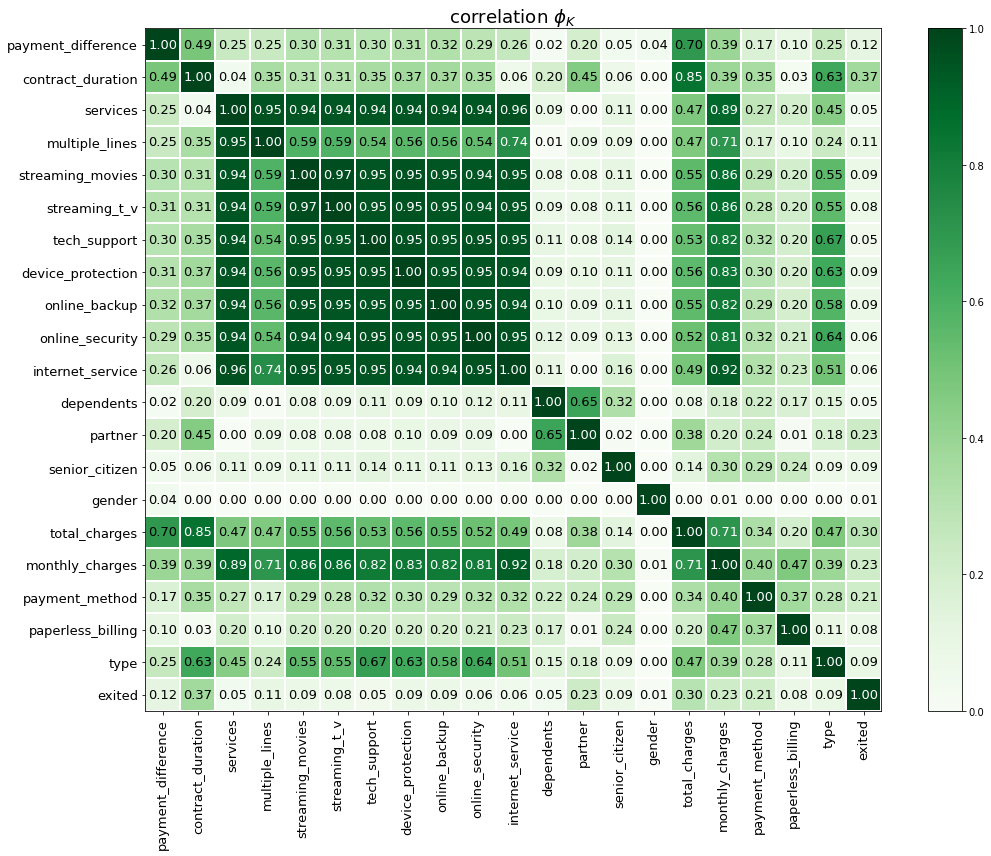

In [56]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.3,
                        figsize=(15, 12))
plt.tight_layout()

Видна сильная корреляция между ежемесячной величиной оплаты (monthly_charges) и наличием интернет-услуг (internet-service).

Также ежемесячные, общие платежи и тип оплаты связаны с наличием почти всех интернет-услуг.


Новая переменная services коррелярует с типом подключения интернет-услуг - коэффициент составляет 0.96.

Перечисленные выше зависимости статистически значимы (см. таблицы ниже). Интересно, что переменная "пол" не коррелярует почти ни с одной перменной, коэффициенты корреляции не значимы.

Статистическая значимость коэффициентов:

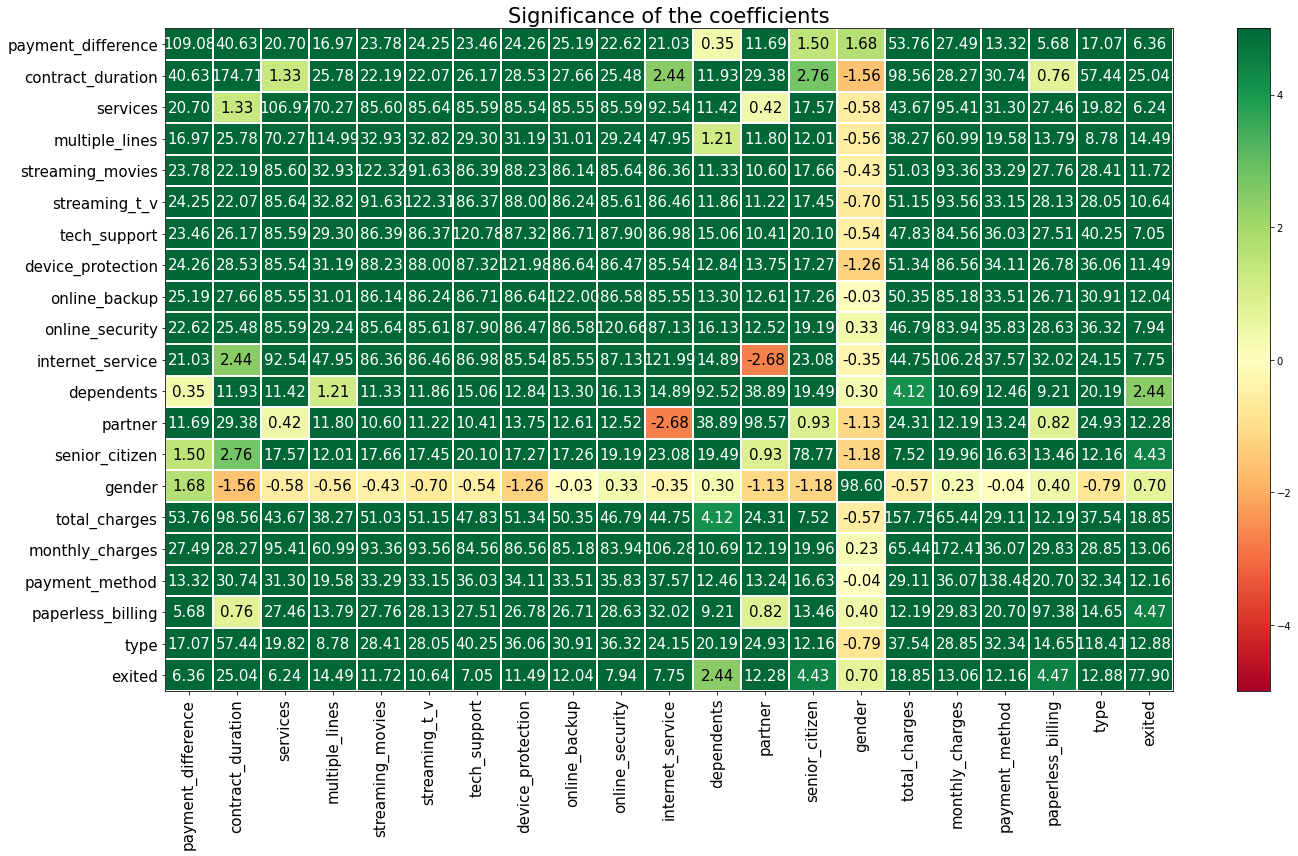

In [57]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=-5, vmax=5, title="Significance of the coefficients",
                        usetex=False, fontsize_factor=1.5, figsize=(20, 12))
plt.tight_layout()

Посмотрим общий коэффициент корреляции - какие переменные наибольшим образом связаны с другими.

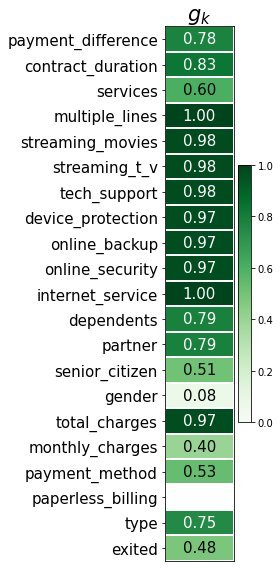

In [58]:
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation,
                        x_labels=[''], y_labels=global_labels,
                        vmin=0, vmax=1, figsize=(4,8),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Самые "связанные" с другими переменные: переменные, связанные с разными типами иниернет-услуг, тип оплаты type, величина суммарных платежей monthly_charges, тип подключения интернета internet_service, длительность контракта contract_duration, разница между платежами payment_difference.

Переменная, которые почти не связана с другими - пол gender.

## Финальный отбор признаков

После исследования корреляции признаков не будем использовать переменные, которые перечисляют интернет-сервисы - они связаны со многими другими переменными, что не очень хорошо для построения модели. Вместо этих нескольких переменных воспользуемся новой переменнной 'services'. Также исключим из анализа ежемесячные платежи 'monthly_charges'.

In [59]:
df = df.drop('online_security', axis= 1)
df = df.drop('online_backup', axis= 1)
df = df.drop('device_protection', axis= 1)
df = df.drop('tech_support', axis= 1)
df = df.drop('streaming_t_v', axis= 1)
df = df.drop('streaming_movies', axis= 1)
df = df.drop('monthly_charges', axis= 1)
df.head()

,exited,type,paperless_billing,payment_method,total_charges,gender,senior_citizen,partner,dependents,internet_service,multiple_lines,services,сontract_duration,payment_difference
0,0,Month-to-month,Yes,Electronic check,31.040001,Female,0,Yes,No,DSL,no_phone,internet,31.0,0.600856
1,0,One year,No,Mailed check,2071.840088,Male,0,No,No,DSL,No,int_and_ph,1036.0,131.044035
2,0,Month-to-month,Yes,Mailed check,226.169998,Male,0,No,No,DSL,No,int_and_ph,123.0,8.290064
3,0,One year,No,Bank transfer (automatic),1960.599976,Male,0,No,No,DSL,no_phone,internet,1371.0,52.925633
4,0,Month-to-month,Yes,Electronic check,353.500000,Female,0,No,No,Fiber optic,No,int_and_ph,153.0,-2.325658


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   exited              7043 non-null   int64  
 1   type                7043 non-null   object 
 2   paperless_billing   7043 non-null   object 
 3   payment_method      7043 non-null   object 
 4   total_charges       7043 non-null   float32
 5   gender              7043 non-null   object 
 6   senior_citizen      7043 non-null   object 
 7   partner             7043 non-null   object 
 8   dependents          7043 non-null   object 
 9   internet_service    7043 non-null   object 
 10  multiple_lines      7043 non-null   object 
 11  services            7043 non-null   object 
 12  сontract_duration   7043 non-null   float64
 13  payment_difference  7043 non-null   float64
dtypes: float32(1), float64(2), int64(1), object(10)
memory usage: 1.0+ MB


## Дисбаланс классов

Посмотрим, какое отношение у классов целевой переменной.

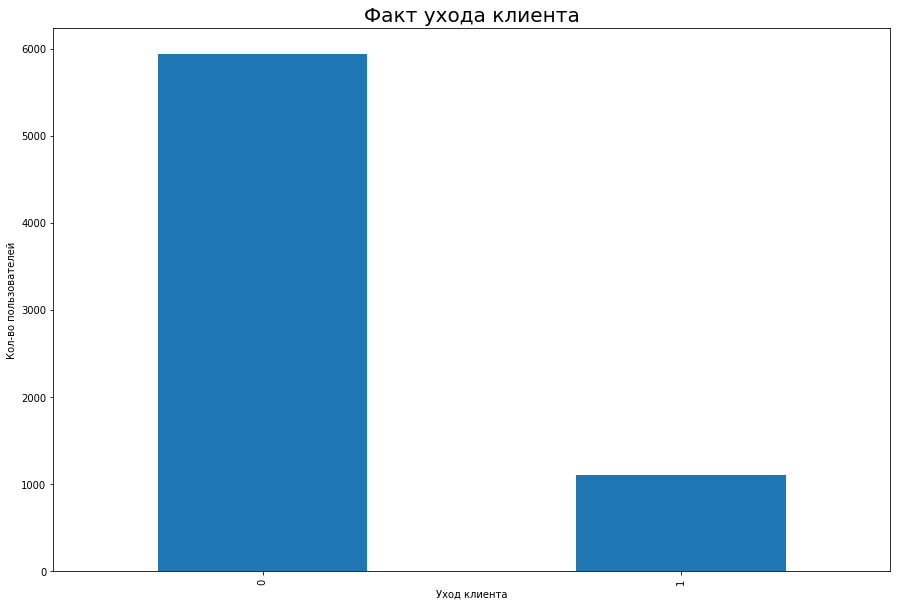

In [61]:
df.groupby('exited')['exited'].count().plot(kind='bar')
plt.title("Факт ухода клиента", fontsize=20)
plt.xlabel("Уход клиента")
plt.ylabel("Кол-во пользователей");

In [62]:
df.groupby('exited')['exited'].count()

exited
0    5942
1    1101
Name: exited, dtype: int64

Почти 6000 наблюдений клиентов, которые остались и больше 1000 тех, кто покинул компанию. Соотношение примерно 84% на 16% - виден дисбаланс классов. Пока ничего с этим делать не будем.

## Распределение признаков

Посмотрим на распределение признаков, удалим из выборки аномальные значения, если потребуется.

### type

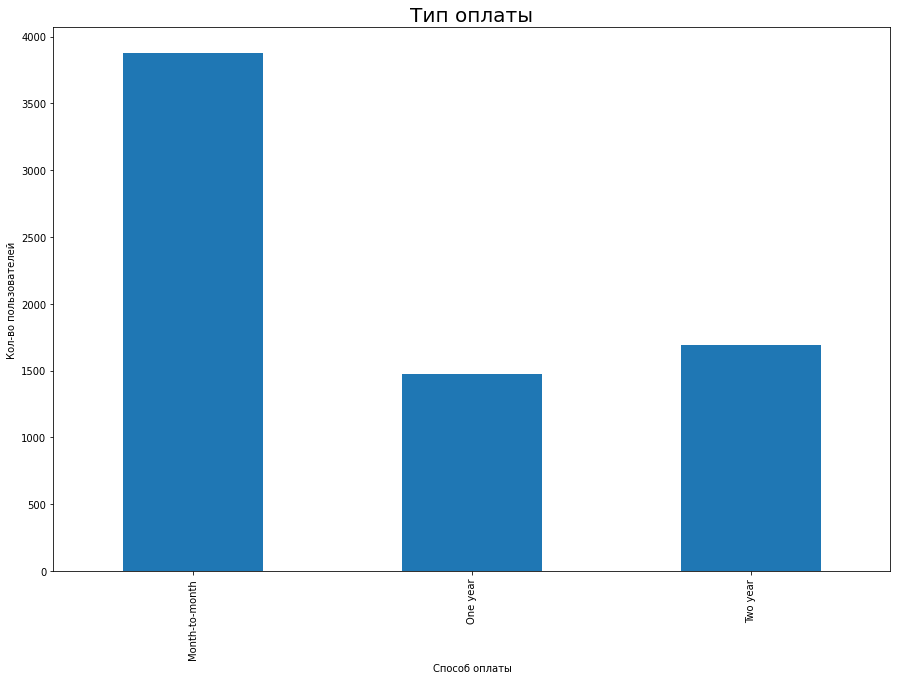

In [63]:
df.groupby('type')['type'].count().plot(kind='bar')
plt.title("Тип оплаты", fontsize=20)
plt.xlabel("Способ оплаты")
plt.ylabel("Кол-во пользователей");

Наиболее популярный способ оплаты - ежемесячная оплата.

### paperless_billing

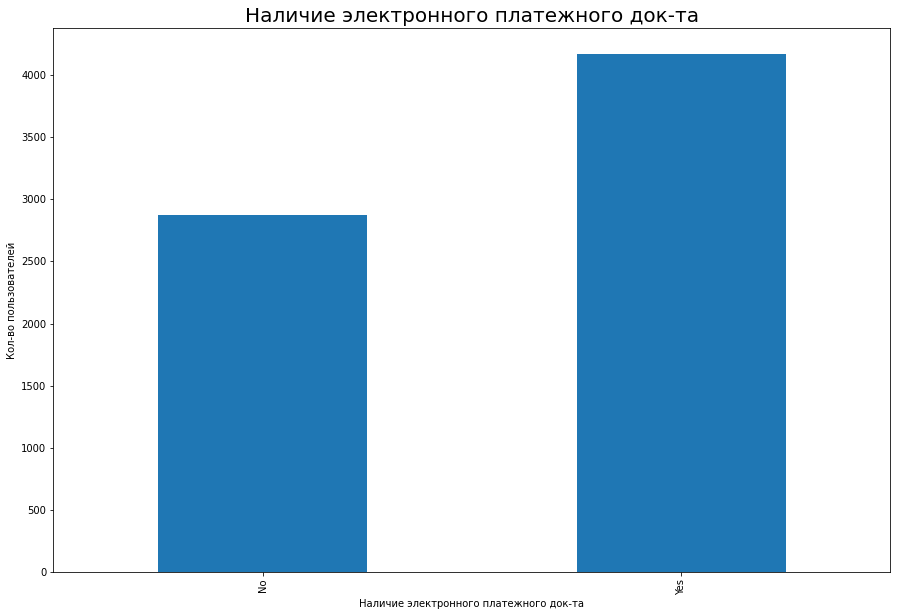

In [64]:
df.groupby('paperless_billing')['paperless_billing'].count().plot(kind='bar')
plt.title("Наличие электронного платежного док-та", fontsize=20)
plt.xlabel("Наличие электронного платежного док-та")
plt.ylabel("Кол-во пользователей");

Чуть больше половины пользователей используют электронный платежный документ.

### payment_method

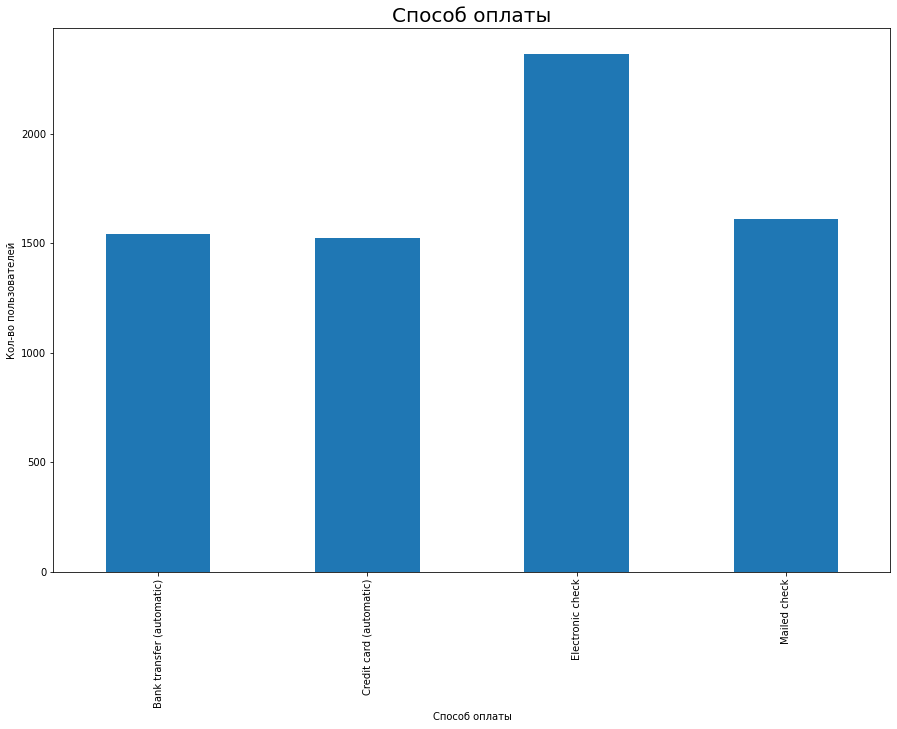

In [65]:
df.groupby('payment_method')['payment_method'].count().plot(kind='bar')
plt.title("Способ оплаты", fontsize=20)
plt.xlabel("Способ оплаты")
plt.ylabel("Кол-во пользователей");

Наиболее популярный способ оплаты - электронный чек. Остальные способы не сильно отстают и находятся примерно на одном уровне друг с другом.

### total_charges

count    7043.000000
mean     2115.312744
std      2112.742676
min         0.000000
25%       436.750000
50%      1343.349976
75%      3236.689941
max      9221.379883
Name: total_charges, dtype: float64


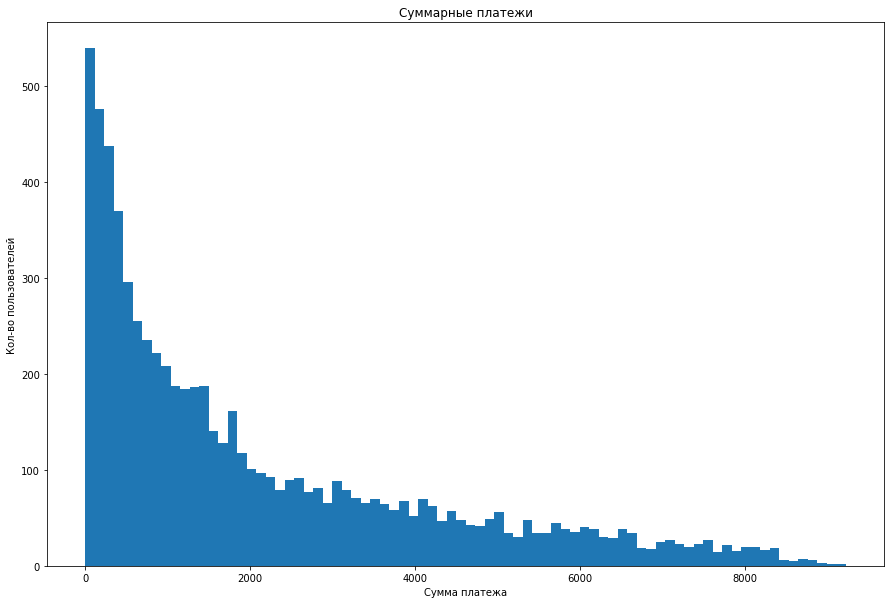

In [66]:
df['total_charges'].plot(kind='hist', bins=80)
plt.title("Суммарные платежи")
plt.xlabel("Сумма платежа")
plt.ylabel("Кол-во пользователей")
print(df['total_charges'].describe());

Всего пользователи тратили на услуги от 19 до 9221 единиц. При этом кол-во пользователей, заплатиших за все время большие суммы, уменьшается. График смещен в левую сторону, наверное, есть большое число новых клиентов, которые не успели заплатить много.

### gender

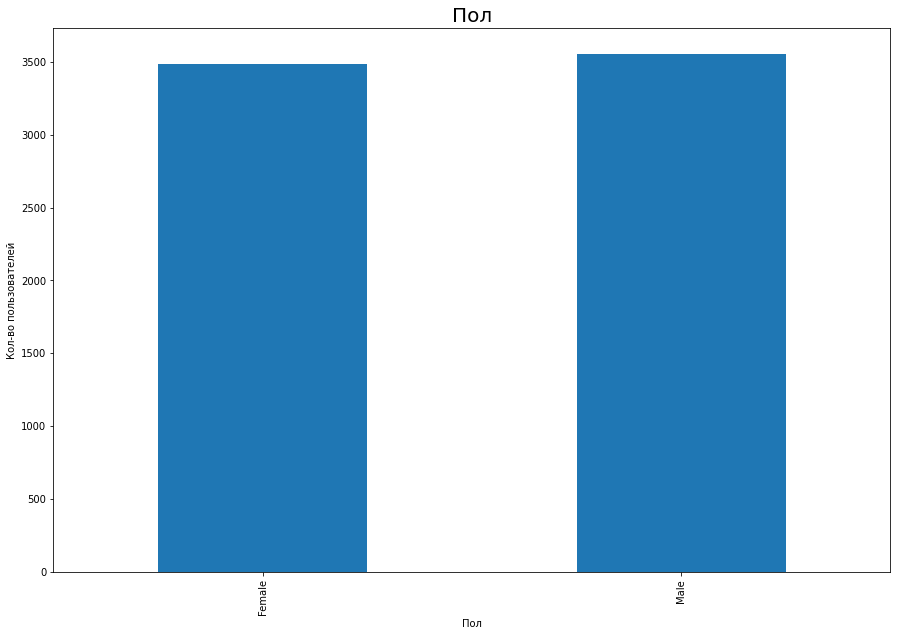

In [67]:
df.groupby('gender')['gender'].count().plot(kind='bar')
plt.title("Пол", fontsize=20)
plt.xlabel("Пол")
plt.ylabel("Кол-во пользователей");

Мужчин и женщин практически поровну.

### senior_citizen

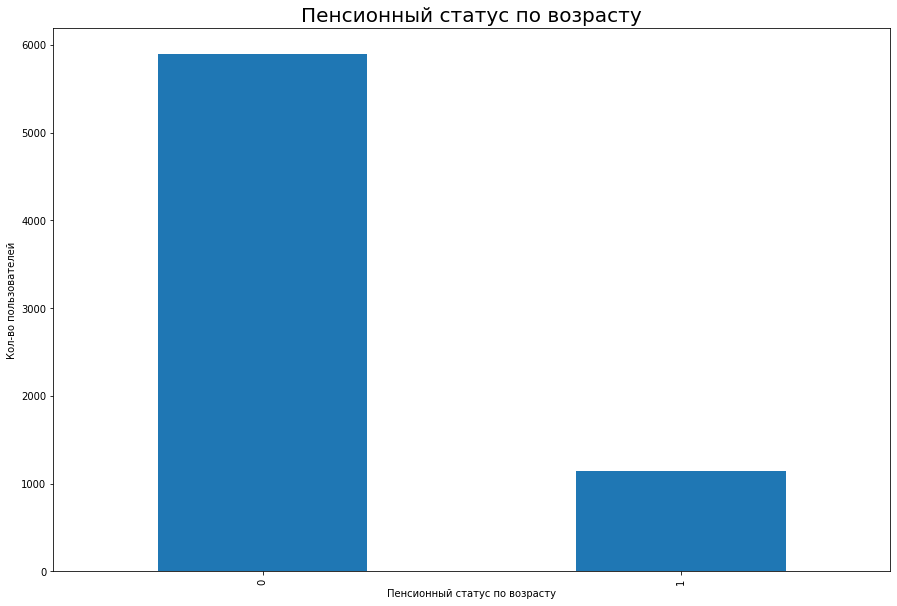

In [68]:
df.groupby('senior_citizen')['senior_citizen'].count().plot(kind='bar');
plt.title("Пенсионный статус по возрасту", fontsize=20)
plt.xlabel("Пенсионный статус по возрасту")
plt.ylabel("Кол-во пользователей");

Пенсионеров почти в 6 раз меньше, чем клиентов допенсионного возраста.

### partner

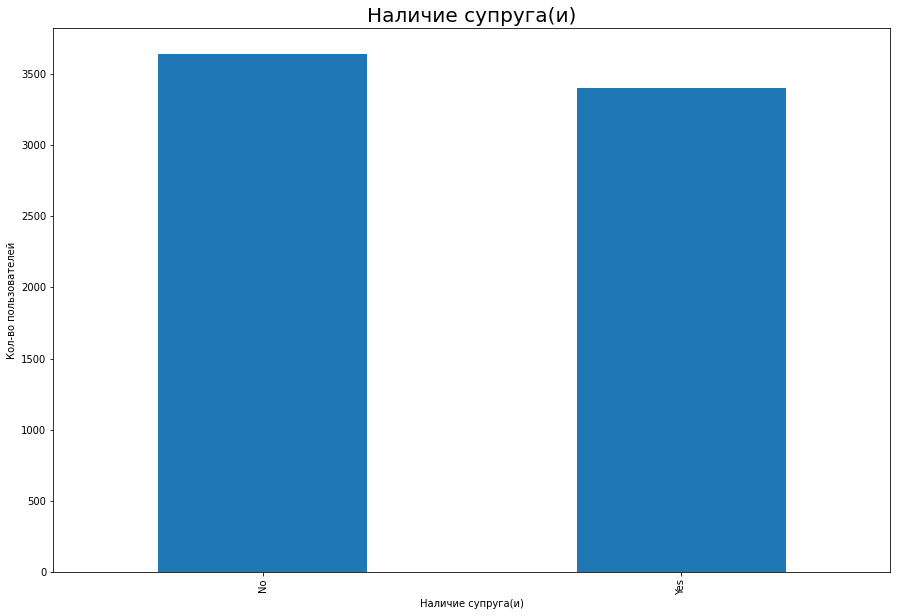

In [69]:
df.groupby('partner')['partner'].count().plot(kind='bar');
plt.title("Наличие супруга(и)", fontsize=20)
plt.xlabel("Наличие супруга(и)")
plt.ylabel("Кол-во пользователей");

Количество клиентов, имеющих и не имеющих супруга/супругу, почти одинаково.

### dependents

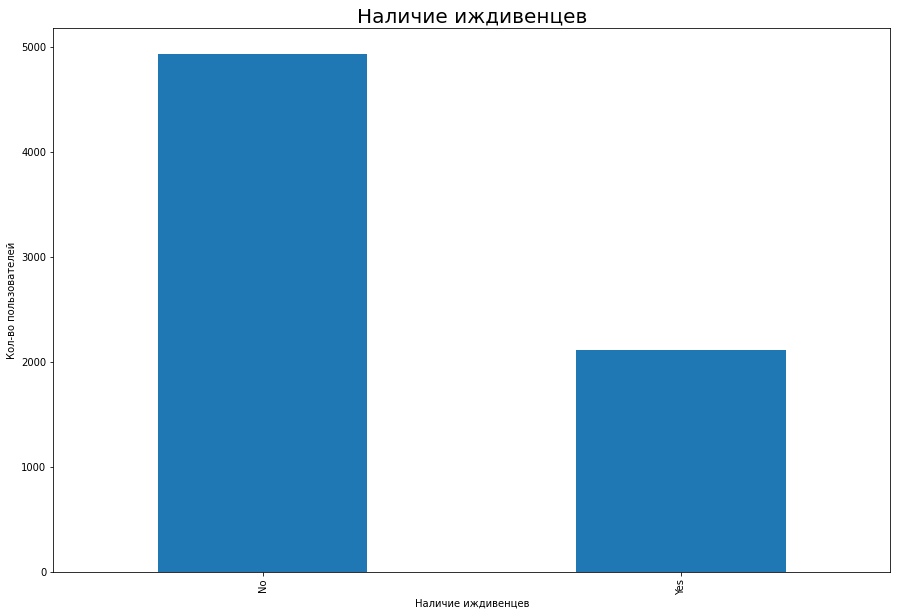

In [70]:
df.groupby('dependents')['dependents'].count().plot(kind='bar');
plt.title("Наличие иждивенцев", fontsize=20)
plt.xlabel("Наличие иждивенцев")
plt.ylabel("Кол-во пользователей");

Количество клиентов, имеющих иждивенцев, более чем в 2 раза меньше тех, кто таких не имеет.

### internet_service

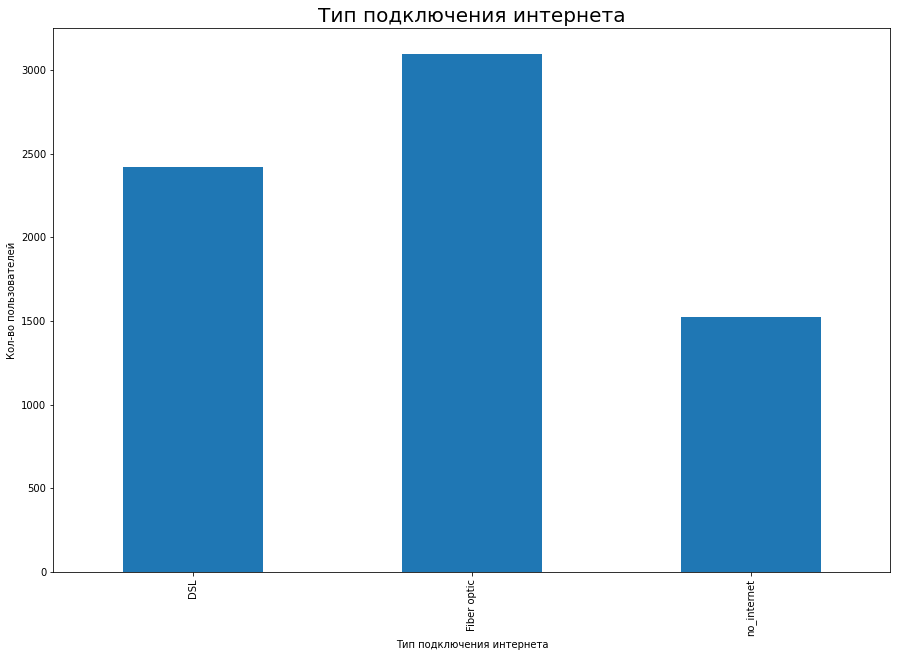

In [71]:
df.groupby('internet_service')['internet_service'].count().plot(kind='bar');
plt.title("Тип подключения интернета", fontsize=20)
plt.xlabel("Тип подключения интернета")
plt.ylabel("Кол-во пользователей");

Оптоволоконный кабель немного более популярен, нежели подключение через телефонную линию. Примерно 20% пользователей не пользуется услугами интернета.

### multiple_lines

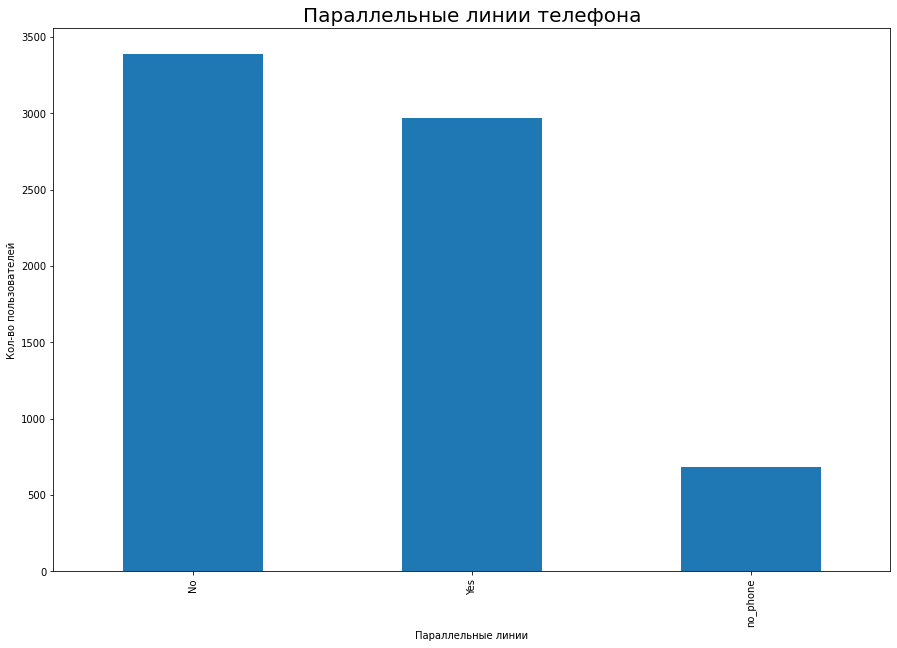

In [72]:
df.groupby('multiple_lines')['multiple_lines'].count().plot(kind='bar')
plt.title("Параллельные линии телефона", fontsize=20)
plt.xlabel("Параллельные линии")
plt.ylabel("Кол-во пользователей");

Почти 3000 клиентов пользуются подключением телефонного аппарата к нескольким линиям одновременно

### services

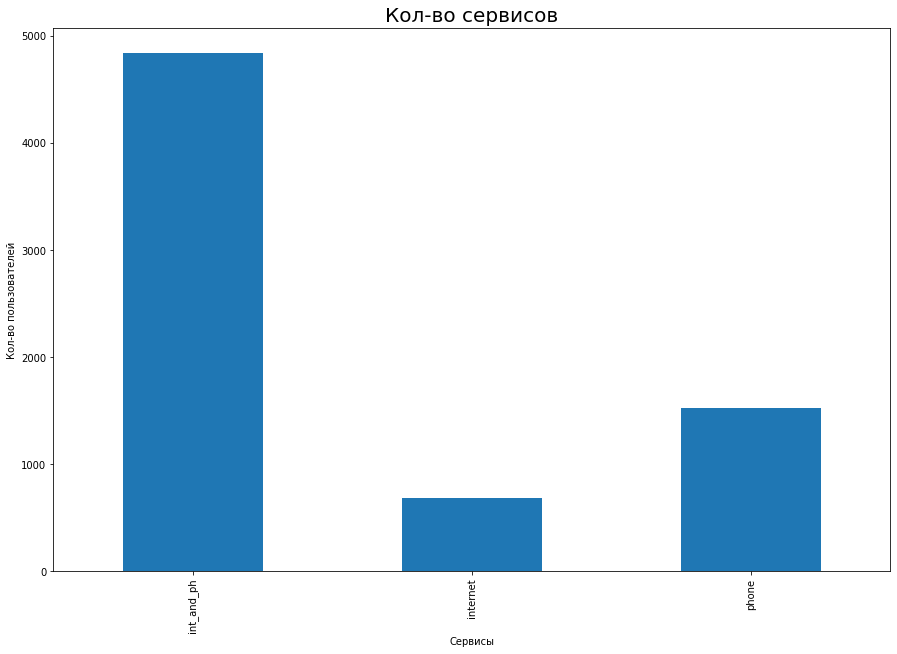

In [73]:
df.groupby('services')['services'].count().plot(kind='bar')
plt.title("Кол-во сервисов", fontsize=20)
plt.xlabel("Сервисы")
plt.ylabel("Кол-во пользователей");

Большая часть клиентов пользуется телефоном и интернетом у оператора одновременно. Самая маленькая часть (меньше 100- абонентов) - только интернетом, около 1500 клиентов - только телефоном.

### сontract_duration

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: сontract_duration, dtype: float64


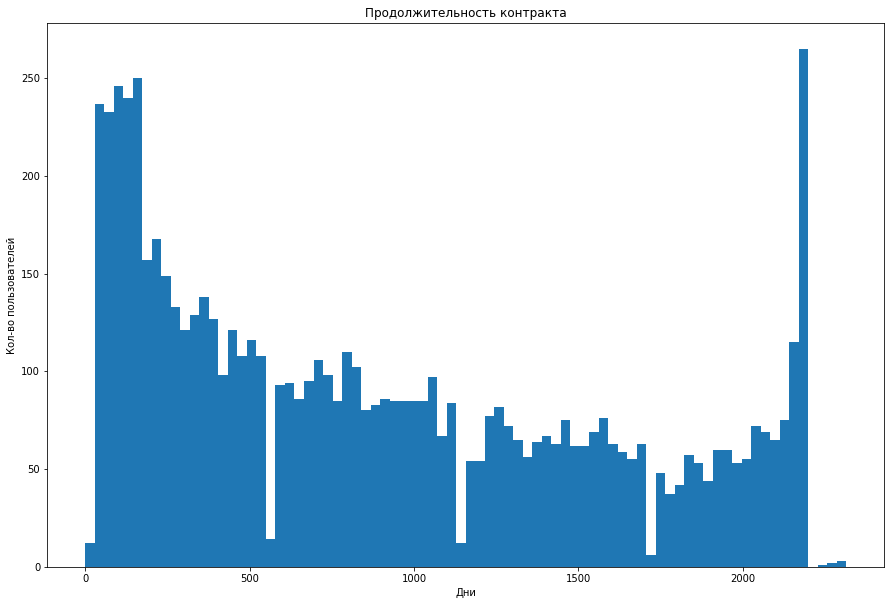

In [74]:
df['сontract_duration'].plot(kind='hist', bins=80)
plt.title("Продолжительность контракта")
plt.xlabel("Дни")
plt.ylabel("Кол-во пользователей");
print(df['сontract_duration'].describe());

В базе представлены абоненты, которые подключены от месяца до почти 6,5 лет назад.

### payment_difference

count    7043.000000
mean       52.330858
std       110.358306
min       -17.590461
25%        -3.129934
50%         0.684344
75%        54.419832
max       829.656199
Name: payment_difference, dtype: float64


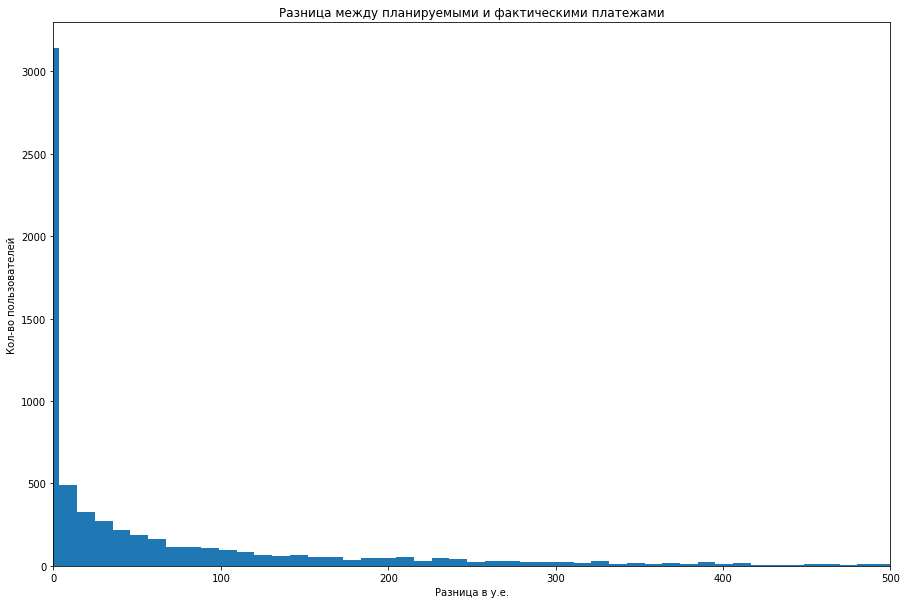

In [75]:
df['payment_difference'].plot(kind='hist', bins=80)
plt.title("Разница между планируемыми и фактическими платежами")
plt.xlabel("Разница в у.е.")
plt.ylabel("Кол-во пользователей")
plt.xlim(0, 500)
print(df['payment_difference'].describe());

У большинства пользователей разница между ежемесячными платежами и общей заплаченной суммой очень маленькая. Есть значения отличающиеся в большую и меньшую сторону.

### Распределение признаков по целевой переменной

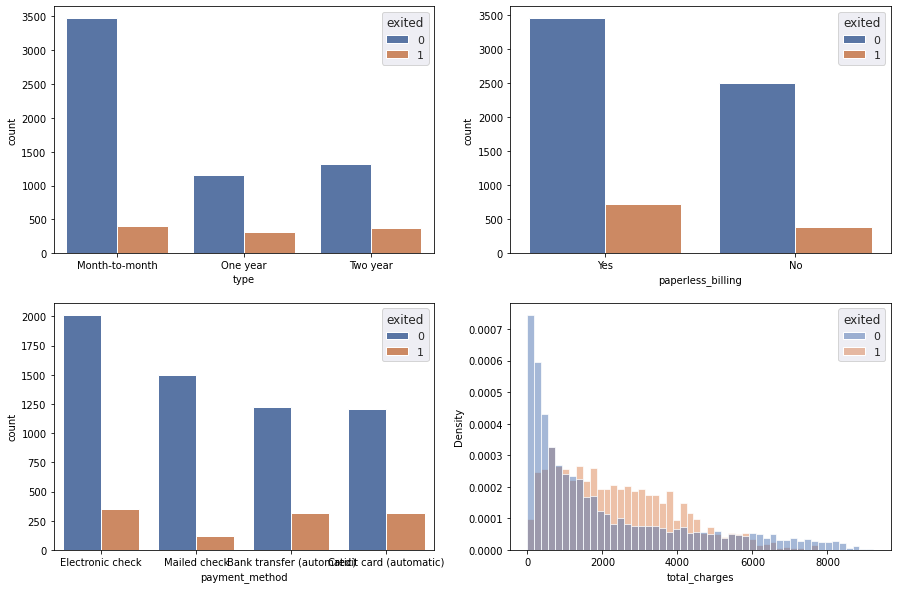

In [76]:
fig, axes = plt.subplots(2, 2)
sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='type', hue='exited', ax=axes[0,0])

sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='paperless_billing', hue='exited', ax=axes[0,1])

sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='payment_method', hue='exited', ax=axes[1,0])

sns.set(rc={'figure.figsize': (12, 8)})
sns.histplot(data=df, x='total_charges', hue='exited', bins=50, stat='density', common_norm=False, ax=axes[1,1]);

Распределение целевой переменной почти одинаково по типу контракта - ежемесячному, когда платят раз в год или раз в два года. 
Доля ушедших клиентов меньше среди тех, кто платит автоматически кредитной картой.
Доля ушедших клиентов возрастает с возрастанием величины общих платежей. А после значения суммарных платежей около 6000 снижается - наверное, это постоянные, лояльные клиенты.

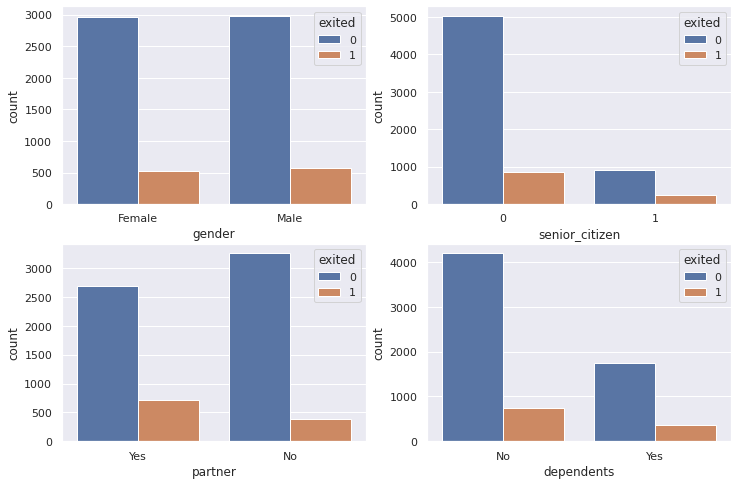

In [77]:
fig, axes = plt.subplots(2, 2)
sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='gender', hue='exited', ax=axes[0,0])

sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='senior_citizen', hue='exited', ax=axes[0,1])

sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='partner', hue='exited', ax=axes[1,0])

sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='dependents', hue='exited', ax=axes[1,1]);

Доля тех, кто ушел, выше среди клиентов, умеющих супруга/супругу. В остальных переменных, представленных выше, характер распределения оставшихся и ушедших клиентов совпадает.

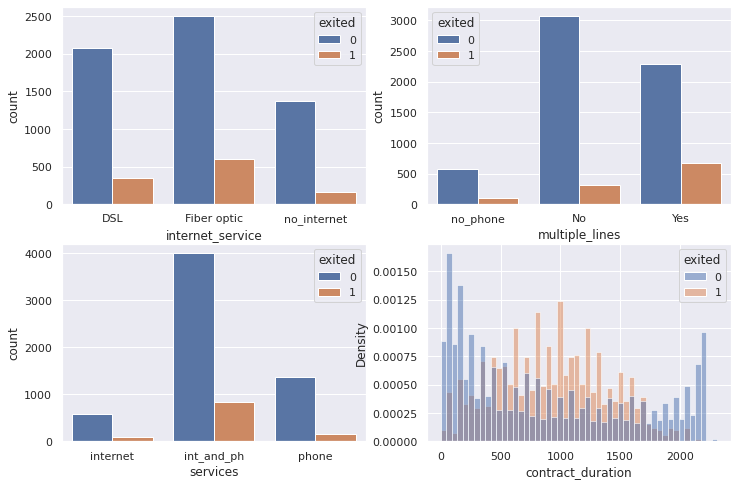

In [78]:
fig, axes = plt.subplots(2, 2)
sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='internet_service', hue='exited', ax=axes[0,0])

sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='multiple_lines', hue='exited', ax=axes[0,1])

sns.set(rc={'figure.figsize': (12, 8)})
sns.countplot(data=df, x='services', hue='exited', ax=axes[1,0])

sns.set(rc={'figure.figsize': (12, 8)})
sns.histplot(data=df, x='сontract_duration', hue='exited', bins=50, stat='density', common_norm=False, ax=axes[1,1]);

Доля ушедших клиентов выше среди тех, кто пользуется телефонами с несколькими линиями одновременно.
Также она выше среди клиентов, пользующихся услугами компании примерно от 500 до 1500 дней (1,5-4 года).

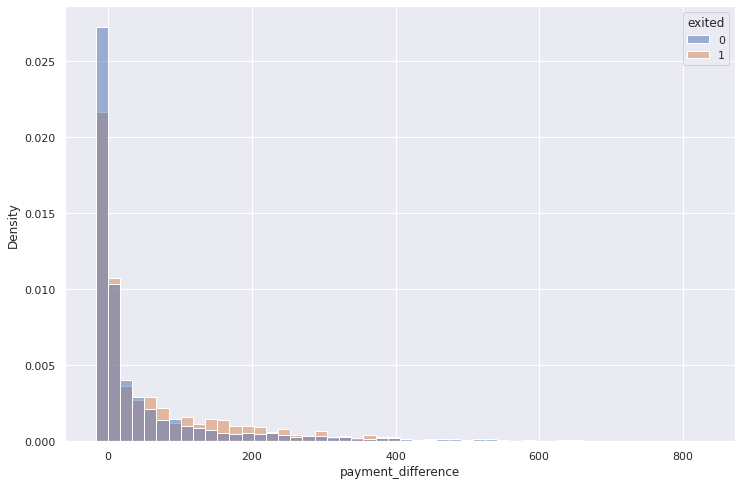

In [79]:
sns.histplot(data=df, x='payment_difference', hue='exited', bins=50, stat='density', common_norm=False);

Доля тех, кто ушел, возрастает с возрастанием разницы между планируемыми и фактическими платежами.

## Вывод

Базы данных были открыты, сведены в одну общую таблицу. Пропущенные значения заполнены, вычислены новые признаки. Данные приведены к нужному типу, проверена кодировка. Данные проверены на корреляцию.

В целевом признаке есть дисбаланс - доля отрицательных и положительных событий находится в соотношении примерно 84% на 16%.

Проанализированы распределения переменных, в том числе распределение по целевой переменной.

# Построение моделей

Для предсказания оттока клиентов используем и сравним четыре модели - логистическую регрессию(LogisticRegression), случайный лес(RandomForestClassifier), модель градиентного бустинга LGBMClassifier и модель градиентного бустинга CatBoostClassifier. Метрикой качества будет AUC-ROC.
Выберем модель с лучшей метрикой качества с помощью кросс-валидации и проверим ее на тестовой выборке.

## Разделение на обучающую и тестовую выборки

Разделим выборку на две - обучающую и тестовую (25%). Так как у нас есть дисбаланс в целевом признаке, при разбиении укажем параметр stratify.

In [80]:
#зададим random_state
RANDOM_STATE = 161023

In [81]:
target = df['exited']
features = df.drop('exited', axis=1)

In [82]:
features_train, features_test, target_train, target_test \
= train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [83]:
print('features_train:')
print(features_train.shape[0])

print('features_test:')
print(features_test.shape[0])

features_train:
5282
features_test:
1761


Выделим категориальные и числовые признаки:

In [84]:
cat_columns = features.select_dtypes(include='object').columns.tolist()
num_columns = features.select_dtypes(include=['float64', 'int64']).columns.tolist()

## LogisticRegression

Построим модель логистической регрессии. Создадим pipeline, с помощью RandomizedSearchCV подберем оптимальные параметры.

In [85]:
column_transformer_regression = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_columns),
                                              remainder='passthrough')

In [86]:
model_regression = LogisticRegression(random_state=RANDOM_STATE)
pipeline_regression = make_pipeline(column_transformer_regression, model_regression)
pipeline_regression

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['сontract_duration',
                                                   'payment_difference']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'multiple_lines',
                                                   'services'])])),
                ('logisticregression',
                 LogisticRegression(random_state=161023))])

In [87]:
params_regression = {'logisticregression__C': (1e-7, 1.0, 3.0, 5.0, 7.0, 10.0),
                    'logisticregression__max_iter': [1000] }

In [88]:
%%time

randomsearch_regression = RandomizedSearchCV(pipeline_regression, params_regression, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
randomsearch_regression.fit(features_train, target_train)

print('AUC-ROC:', randomsearch_regression.best_score_)
print('Лучшие параметры модели:', randomsearch_regression.best_params_)

AUC-ROC: 0.7375657516797426
Лучшие параметры модели: {'logisticregression__max_iter': 1000, 'logisticregression__C': 3.0}
CPU times: user 22.2 s, sys: 26.6 s, total: 48.9 s
Wall time: 48.9 s


## RandomForestClassifier

Построим модель случайного леса. Создадим pipeline, с помощью RandomizedSearchCV подберем оптимальные параметры.

In [89]:
column_transformer_forest = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_columns),
                                              remainder='passthrough')

In [90]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)
pipeline_forest = make_pipeline(column_transformer_forest, model_forest)
pipeline_forest

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['сontract_duration',
                                                   'payment_difference']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'multiple_lines',
                                                   'services'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=161023))])

In [91]:
params_forest = {'randomforestclassifier__n_estimators': range(10, 100),
                 'randomforestclassifier__max_depth': range(2, 15)
         }

In [92]:
%%time

randomsearch_forest = RandomizedSearchCV(pipeline_forest, params_forest, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
randomsearch_forest.fit(features_train, target_train)

print('AUC-ROC:', randomsearch_forest.best_score_)
print('Лучшие параметры модели:', randomsearch_forest.best_params_)

AUC-ROC: 0.839733697767117
Лучшие параметры модели: {'randomforestclassifier__n_estimators': 42, 'randomforestclassifier__max_depth': 9}
CPU times: user 11.2 s, sys: 39.6 ms, total: 11.2 s
Wall time: 11.8 s


## LGBMClassifier

Построим модель LGBMClassifier. Создадим pipeline, с помощью RandomizedSearchCV подберем оптимальные параметры.

In [93]:
column_transformer_lgbm = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_columns),
                                              remainder='passthrough')

Так как у нас заметен дисбаланс классов, укажем параметр is_unbalance=True:

In [94]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True)  
pipeline_lgbm = make_pipeline(column_transformer_lgbm, model_lgbm)
pipeline_lgbm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['сontract_duration',
                                                   'payment_difference']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'multiple_lines',
                                                   'services'])])),
                ('lgbmclassifier',
                 LGBMClassifier(is_unbalance=True, random_state=161023))])

In [95]:
params_lgbm = {'lgbmclassifier__n_estimators': range(10, 1000),
          'lgbmclassifier__max_depth': range(2, 20),
          'lgbmclassifier__subsample_for_bin': (200000, 300000),
          'lgbmclassifier__num_leaves': (2, 200)   
         }

In [96]:
%%time

randomsearch_lgbm = RandomizedSearchCV(pipeline_lgbm, params_lgbm, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
randomsearch_lgbm.fit(features_train, target_train)

print('AUC-ROC:', randomsearch_lgbm.best_score_)
print('Лучшие параметры модели:', randomsearch_lgbm.best_params_)

AUC-ROC: 0.8899208290490146
Лучшие параметры модели: {'lgbmclassifier__subsample_for_bin': 200000, 'lgbmclassifier__num_leaves': 200, 'lgbmclassifier__n_estimators': 755, 'lgbmclassifier__max_depth': 4}
CPU times: user 1h 13s, sys: 21.5 s, total: 1h 34s
Wall time: 1h 1min 6s


## CatBoostClassifier

Построим модель CatBoostClassifier. Создадим pipeline, с помощью RandomizedSearchCV подберем оптимальные параметры.

In [97]:
column_transformer_catboost = make_column_transformer((StandardScaler(), num_columns),
                                             (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_columns),
                                              remainder='passthrough')

In [98]:
model_catboost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False) #, is_unbalance=True)  
pipeline_catboost = make_pipeline(column_transformer_catboost, model_catboost)
pipeline_catboost

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['сontract_duration',
                                                   'payment_difference']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'multiple_lines',
                                                   'services'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f97ee79cca0>)])

In [99]:
params_catboost = {'catboostclassifier__depth': range(2, 20),
                   'catboostclassifier__iterations': range(100, 300)   
         }

In [100]:
%%time

randomsearch_catboost = RandomizedSearchCV(pipeline_catboost, params_catboost, cv=5, scoring='roc_auc', random_state=RANDOM_STATE)
randomsearch_catboost.fit(features_train, target_train)

print('AUC-ROC:', randomsearch_catboost.best_score_)
print('Лучшие параметры модели:', randomsearch_catboost.best_params_)

AUC-ROC: 0.8830594738551447
Лучшие параметры модели: {'catboostclassifier__iterations': 286, 'catboostclassifier__depth': 4}
CPU times: user 37min 47s, sys: 15min 51s, total: 53min 38s
Wall time: 54min 23s


## Лучшая модель

Лучше всего себя показал алгоритм LGBMClassifier со значением целевой метрики AUC-ROC 0.89. Оптимальные параметры модели следующие:

```
'random_state'=RANDOM_STATE, 
'is_unbalance'=True,
'subsample_for_bin': 200000,
'num_leaves': 200, 
'n_estimators': 755, 
'max_depth': 4
```

На втором месте - CatBoostClassifier с метрикой качества 0.88, далее - случайный лес c метрикой AUC-ROC 0.84, потом - логистическая регрессия с метрикой 0.74.

## Проверка на тестовой выборке

Проверим лучшую модель LGBMClassifier на тестовой выборке. Выведем значения AUC-ROC и accuracy.

In [101]:
lgbm_test = randomsearch_lgbm.predict(features_test)
probabilities_test = randomsearch_lgbm.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_auc = roc_auc_score(target_test, probabilities_one_test)
test_accuracy = accuracy_score(target_test, lgbm_test)
print('auc_roc на тестовой выборке:', test_auc)
print('accuracy на тестовой выборке:', test_accuracy)

auc_roc на тестовой выборке: 0.9126514131897712
accuracy на тестовой выборке: 0.8977853492333902


Целевая метрика AUC-ROC на тестовой выборке равна 0.91, что на 2 процентных пункта выше, чем у модели LGBMClassifier на обучающей выборке. Это значит, что модель работает достаточно стабильно и на ее результаты можно положиться.

AUC-ROC (от англ. Area Under Curve ROC «площадь под ROC-кривой») находится в диапазоне от 0 до 1 и описывает отношение между долей ложноположительных и истинно положительных ответов. Значит, значение 0.91 по тестовой выборке достаточно высокий показатель.

Accuracy показывает долю верных предсказаний в целом, без привязке к доли ложноположительных и истинно положительных ответов. Значение 0.897 означает, что, почти 90% наблюдений по тестовой выборке предсказано верно.

## Важность признаков

Посмотрим, какие признаки вносят бОльший вклад в объяснение целевой переменной.

In [102]:
pipeline_lgbm.fit(features_train, target_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['сontract_duration',
                                                   'payment_difference']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'multiple_lines',
                                                   'services'])])),
                ('lgbmclassifier',
                 LGBMClassifier(is_unbalance=True, random_state=161023))])

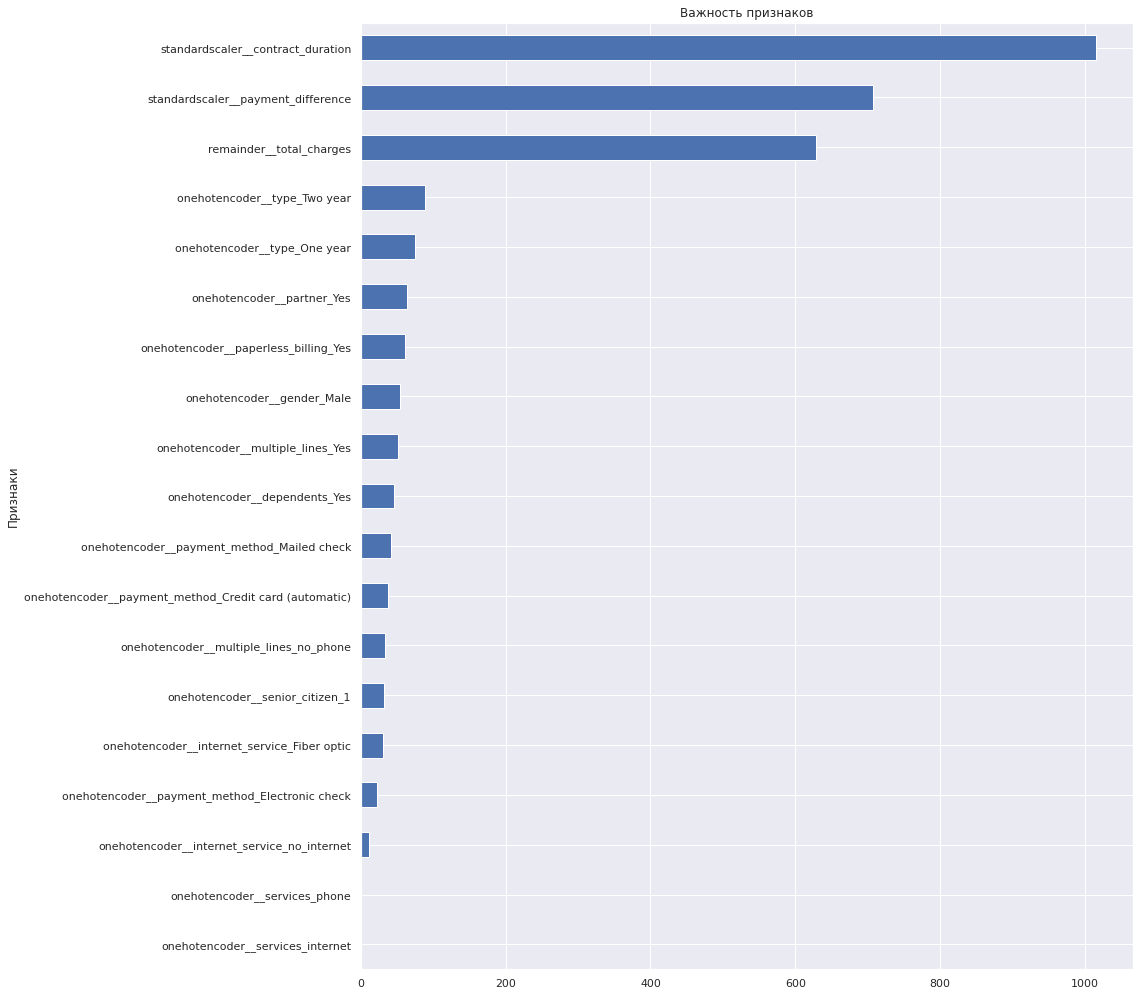

In [103]:
features_model_lgbm = pd.Series(pipeline_lgbm.named_steps['lgbmclassifier'].feature_importances_,
                         column_transformer_lgbm.get_feature_names_out()).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(16,14))
features_model_lgbm.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Признаки')
fig.tight_layout()

Три переменные вносят наибольший вклад в определении целевой переменой, это:

```
-Продолжительность контракта (сontract_duration)
-Разница между планируемыми и фактическими платежами(payment_difference)
-Суммарные платежи (total_charges)
```

Остальные переменные имеют значительно меньше влияния, чем перечисленные выше.

## Матрица ошибок

Посмотрим, как наша модель объясняет принадлежность клиентов к каждому классу. Для этого загрузим "матицу ошибок".

Абсолютные значения:

In [104]:
cm_lgbm = confusion_matrix(target_test, lgbm_test)
cm_lgbm_share = pd.DataFrame(cm_lgbm)
cm_lgbm_share

,0,1
0,1380,106
1,74,201


Относительные значения:

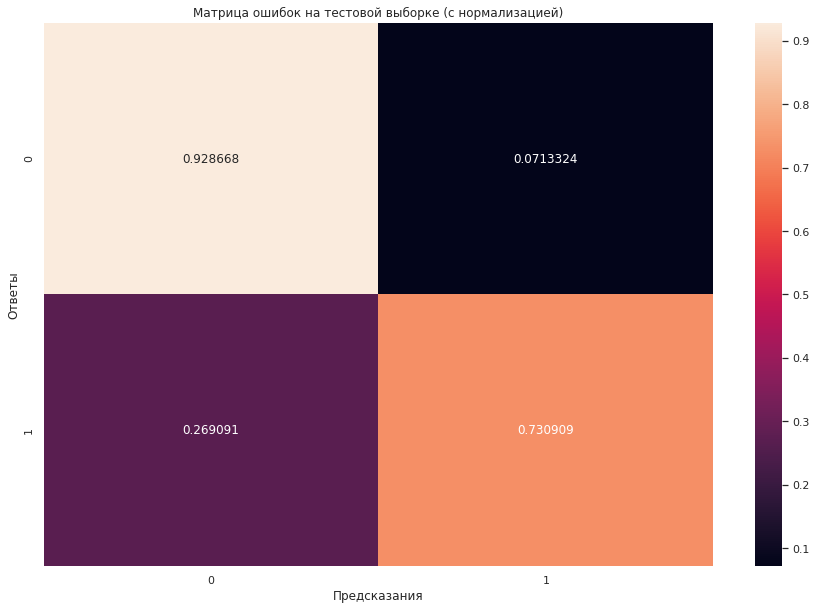

In [105]:
cm = confusion_matrix(target_test, lgbm_test, normalize='true')
plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Матрица ошибок на тестовой выборке (с нормализацией)')
plt.ylabel('Ответы')
plt.xlabel('Предсказания')
plt.show()

Матрица показывает, что модель верно предсказала 73% ушедших клиентов (истинно положительные предсказания).  Оставшимся 27% ушедших клиентов модель присвоила метку 0 , что означает, что клиент не должен уйти из компании (ложноотрицательные предсказания).

Модель верно предсказала 93% оставшихся клиентов (истинно отрицательные предсказания). А 7% клиентов, которые не собираются уходить, присвоила значение 1, то есть ошибочно предсказала их уход (ложноположительные предсказания).

## Вывод

Было протестировано четыре модели - логистическая регрессия(LogisticRegression), случайный лес(RandomForestClassifier), модель градиентного бустинга LGBMClassifier и модель градиентного бустинга CatBoostClassifier. Лучше всего себя показала модель LGBMClassifier с метрикой AUC-ROC 0.91 на тестовой выборке.

Три переменные вносят наибольший вклад в определении целевой переменой, это:

```
-Продолжительность контракта (сontract_duration)
-Разница между планируемыми и фактическими платежами(payment_difference)
-Суммарные плвтежи (total_charges)
```

Видно, что модель хуже предсказывает факт ухода клиента, чем то, что он не собирается уходить (73% против 93%). В целом, это довольно неплохой результат. Можно попробовать удержать около трех четвертых недовольных клиентов. При этом величина ошибочной рассылки не очень велика (7% от тех, кто не собирается уходить), что не должно сильно отразиться на прибыли компании.

# Отчет

**1. Ключевые шаги работы над проектом.**

Цель проекта - разработать модель машинного обучения, которая будет предсказывать отток клиентов оператора связи «Ниединогоразрыва.ком», чтобы на основе этих данных проводить мероприятия по удержанию текущих клиентов в компании (с помощью промокодов и специальных условий).

Задачи:

1. Загрузить и изучить данные
2. Подготовить данные для анализа
3. Построить несколько моделей предсказаний 
4. Выбрать оптимальную модель и протестировать ее
5. Написать выводы и рекомендации

**2. Соответствие фактической работы запланированным задачам.**

В ходе проведения исследования удалось реализовать все запланированные пункты. 

    1. Загрузить и изучить данные:
    Были загружены 4 исходных базы данных, рассмотрена общая информация, данные проверены на дубликаты.

        
    2. Подготовить данные для анализа:
        1) Исходные базы данных соединены в итоговую таблицу
        2) Созданы новые признаки
        3) Заполнены пропуски
        4) Отобраны признаки для анализа 
        5) Признаки перекодированы в вид, требуемый для построения моделей
        6) Типы данных приведены к нужному   
        7) Исследована корреляция с помощью библиотеки phik
        8) Проведена оценка дисбаланса классов
        9) Проанализировано распределение признаков - каждого отдельно и в разрезе целевого признака (ухода клиента)
        10) Обработаны аномальные значения
 
    3. Построить несколько моделей предсказаний:
    Выборка разделена на обучающую и тестовую, признаки обработаны - категориальнын закодированы, числовые - нормализованы. 
    С помощью кросс-валидации построены следующие модели: логистическая регрессия(LogisticRegression), случайный лес(RandomForestClassifier), модель градиентного бустинга LGBMClassifier и модель градиентного бустинга CatBoostClassifier.

        
    4. Выбрать оптимальную модель и протестировать ее на тестовой выборке (по метрике AUC-ROC):
    Оптимальная модель выбрана и протестирована на тестовой выборке.
    
    5. Написать выводы и рекомендации:
    Выводы и рекомендации написаны

**3. Сложности и пути их решения**

1) Первая сложность заключается в том, что после объединения исходных таблиц в данных появилось много пропусков. Это связано с тем, что некоторые пользователи пользуются только одним направленим услуг - телефоном или интернетом. Пропущенные данные были заполнены в соответствии с этой информацией.

2) Вторая сложность - данные записаны в разном формате. В процессе обработки нужно было привести данные к нужному типу, иначе модели работали бы неправильно.  

**4. Предобработка данных**

    1) Исходные базы данных соединены в итоговую таблицу.
    
    2) Созданы новые признаки:
        Services - сколькими направлениями пользуется клиент (только интернет, только телефон, интернет и телефон)
        Сontract_duration - сколько дней клиент является клиентом компании
        Payment_difference - разница между плановыми (величиной ежемесячных пдатежей) и фактическими общими платежами 
        
    3) Заполнены пропуски - пропущенным значениям присвоивались метки, что человек не пользуется интернетом, либо телефонией.
    
    4) Отобраны признаки для анализа (см. следующий пункт).
    
    5) Признаки перекодированы в вид, требуемый для построения моделей (см. следующий пункт).
    
    6) Типы данных приведены к нужному - категориальным признакам присвоен тип object,  количественным - float или int (см. следующий пункт).
    
    7) Корреляция признаков:
    Видна сильная корреляция между ежемесячной величиной оплаты (monthly_charges) и наличием интернет-услуг (internet-service).
    Также ежемесячные, общие платежи и тип оплаты связаны с наличием почти всех интернет-услуг.
    Есть сильная корреляция между фактом ухода клиента (end_date) и разницей между планируемыми и фактическими платежами (payment_difference).
    Новая переменная services коррелярует с типом подключения интернет-услуг - коэффициент составляет 0.96.
    Перечисленные выше зависимости статистически значимы (см. таблицы ниже). Интересно, что переменная "пол" не коррелярует почти ни с одной перменной, коэффициенты корреляции не значимы.
    
    8) Проведена оценка дисбаланса классов:
    Почти 6000 наблюдений клиентов, которые остались и больше 1000 тех, кто покинул компанию. Соотношение примерно 84% на 16% - виден дисбаланс классов. При построении моделей это будет учтено при разбиении выборки на обучающую и тестовую. А также внутри модели градиентного бустинга LGBMClassifier.
    
    9) Проанализировано распределение признаков - каждого отдельно и в разрезе целевого признака (ухода клиента):
    

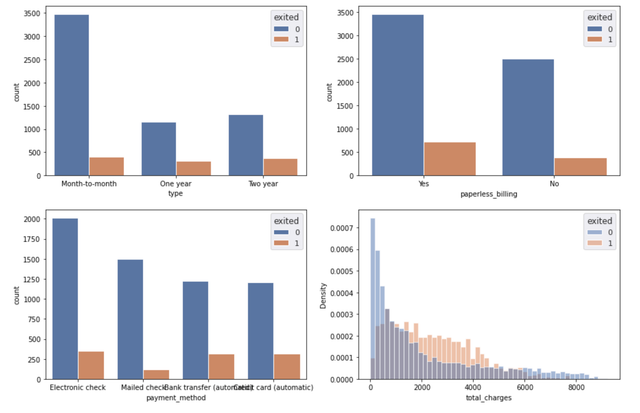

In [106]:
Image("https://i.ibb.co/MDprJCF/2023-10-30-03-06-24.png") 

    Распределение целевой переменной почти одинаково по типу контракта - ежемесячному, когда платят раз в год или раз в два года. Доля ушедших клиентов меньше среди тех, кто платит автоматически кредитной картой. Доля ушедших клиентов возрастает с возрастанием величины общих платежей. А после значения суммарных платежей около 6000 снижается - наверное, это постоянные, лояльные клиенты.

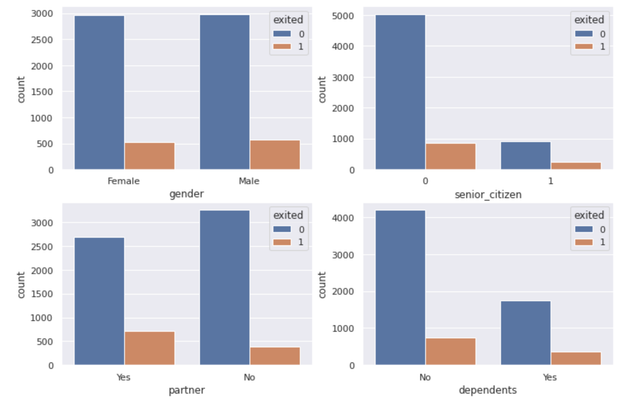

In [107]:
Image("https://i.ibb.co/JKr00gq/2023-10-30-03-06-41.png") 

    Доля тех, кто ушел, выше среди клиентов, умеющих супруга/супругу. В остальных переменных, представленных выше, характер распределения оставшихся и ушедших клиентов совпадает.

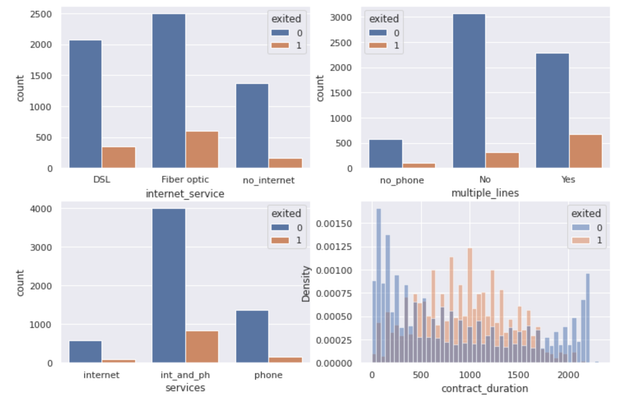

In [108]:
Image("https://i.ibb.co/JRLswwV/2023-10-30-03-06-56.png") 

    Доля ушедших клиентов выше среди тех, кто пользуется телефонами с несколькими линиями одновременно. Также она выше среди клиентов, пользующихся услугами компании примерно от 500 до 1500 дней (1,5-4 года).

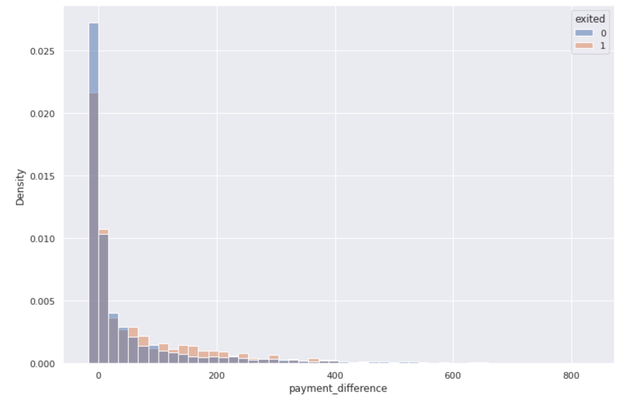

In [109]:
Image("https://i.ibb.co/kSx1dRS/2023-10-30-03-07-16.png")

    Доля тех, кто ушел, возрастает с возрастанием разницы между планируемыми и фактическими платежами.

    10) Обработаны аномальные значения:
    Аномальные значения выявлены не были.

**5. Итоговый список признаков**

После анализа корреляции признаков и их значимости в моделях, были отобраны следующие признаки для анализа: 

```
exited - факт ухода клиента, целевая переменная (int64)

type - тип оплаты (ежемесячный, годовой и т.д.) (object, кодирование OneHotEncoder)

paperless_billing - электронный платежный документ (object, кодирование OneHotEncoder)

payment_method - способ оплаты (object, кодирование OneHotEncoder)

total_charges - всего потрачено денег на услуги (float32, масштабирование с помощью StandardScaler)

gender - пол (object, кодирование OneHotEncoder)

senior_citizen - пенсионный статус по возрасту (object, кодирование OneHotEncoder)

partner - наличие супруга(и) (object, кодирование OneHotEncoder)

dependents - наличие иждивенцев (object, кодирование OneHotEncoder)

internet_service - тип подключения интернета (object, кодирование OneHotEncoder)

multiple_lines - возможно подключения телефонного аппарата к нескольким линиям одновременно (object, кодирование OneHotEncoder)

services - сколькими направлениями пользуется клиент (только интернет, только телефон, интернет и телефон) (object, кодирование OneHotEncoder)

сontract_duration - сколько дней клиент является клиентом компании (float64, масштабирование с помощью StandardScaler)

payment_difference - разница между плановыми (величиной ежемесячных пдатежей) и фактическими общими платежами (float64, масштабирование с помощью StandardScaler)
```

**6. Модели и метрики**

Для предсказания оттока клиентов было построено четыре модели: логистическая регрессия(LogisticRegression), случайный лес(RandomForestClassifier), модель градиентного бустинга LGBMClassifier и модель градиентного бустинга CatBoostClassifier. Метрика качества -  AUC-ROC. Далее была выбрана модель с лучшей метрикой качества с помощью кросс-валидации и проверена ее на тестовой выборке.

Выборка разделена на две - обучающую и тестовую (25%). Зафиксирован параметр RANDOM_STATE = 161023 для воспроизводимости результатов моделей.

Модель и ее метрика на кросс-валидации:

1. LogisticRegression - 0.74
2. RandomForestClassifier - 0.84
3. LGBMClassifier - 0.89
4. CatBoostClassifier - 0.88

**7. Лучшая модель**

Лучше всего себя показал алгоритм LGBMClassifier со значением целевой метрики AUC-ROC 0.89. Оптимальные параметры модели следующие:

```
'random_state'=161023, 
'is_unbalance'=True,
'subsample_for_bin': 200000,
'num_leaves': 200, 
'n_estimators': 755, 
'max_depth': 4
```

**8. Итоговая метрика на тестовой выборке**

AUC-ROC на тестовой выборке: 0.91
Accuracy на тестовой выборке: 0.897

Целевая метрика AUC-ROC на тестовой выборке равна 0.91, что на 2 процентных пункта выше, чем у модели LGBMClassifier на обучающей выборке. Это значит, что модель работает достаточно стабильно и на ее результаты можно положиться.

AUC-ROC (от англ. Area Under Curve ROC «площадь под ROC-кривой») находится в диапазоне от 0 до 1 и описывает отношение между долей ложноположительных и истинно положительных ответов. Значит, значение 0.91 по тестовой выборке достаточно высокий показатель.

Accuracy показывает долю верных предсказаний в целом, без привязке к доли ложноположительных и истинно положительных ответов. Значение 0.897 означает, что, почти 90% наблюдений по тестовой выборке предсказано верно.

**9. Матрица ошибок**

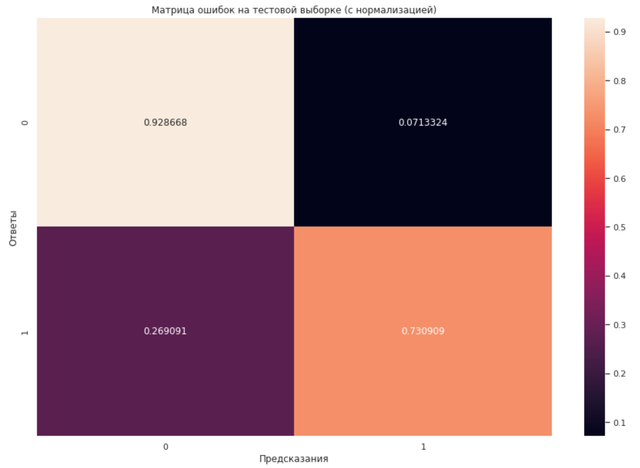

In [110]:
Image("https://i.ibb.co/cFkwn7f/2023-10-30-02-28-23.png") 

Матрица показывает, что модель верно предсказала 73% ушедших клиентов (истинно положительные предсказания). Оставшимся 27% ушедших клиентов модель присвоила метку 0 , что означает, что клиент не должен уйти из компании (ложноотрицательные предсказания).

Модель верно предсказала 93% оставшихся клиентов (истинно отрицательные предсказания). А 7% клиентов, которые не собираются уходить, присвоила значение 1, то есть ошибочно предсказала их уход (ложноположительные предсказания).

Видно, что модель хуже предсказывает факт ухода клиента, чем то, что он не собирается уходить (73% против 93%). В целом, это довольно неплохой результат. Можно попробовать удержать около трех четвертых недовольных клиентов. При этом величина ошибочной рассылки не очень велика (7% от тех, кто не собирается уходить), что не должно сильно отразиться на прибыли компании.

**10. Важность признаков**

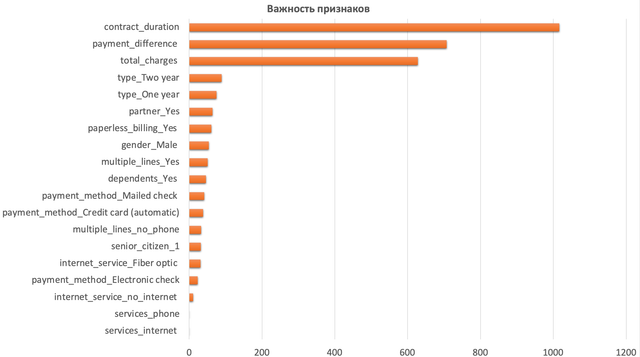

In [111]:
Image("https://i.ibb.co/MDddL3L/2023-10-30-03-40-51.png")

Три переменные вносят наибольший вклад в определении целевой переменой, это:

```
-Продолжительность контракта (сontract_duration)
-Разница между планируемыми и фактическими платежами(payment_difference)
-Суммарные платежи (total_charges)
```

Остальные переменные имеют значительно меньше влияния, чем перечисленные выше.